<a href="https://colab.research.google.com/github/mufti19/self-organizing-maps/blob/main/Final_Project_Versi_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import gdown
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.cluster import KMeans
from scipy.stats import skew
from scipy.stats import boxcox
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
file_id = '1kIXpkpjEmonYCn_VNw7a-2p1CflaAuoa'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'data.csv', quiet=False)

d_listing = pd.read_csv('data.csv')
d_listing.head(1)

Downloading...
From: https://drive.google.com/uc?export=download&id=1kIXpkpjEmonYCn_VNw7a-2p1CflaAuoa
To: /content/data.csv
100%|██████████| 16.9M/16.9M [00:00<00:00, 83.8MB/s]


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [3]:
file_id = '1X9a59SPipMZopcy2XJ7zvbfZNnjDnhtV'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'data.csv', quiet=False)

d_calender = pd.read_csv('data.csv')
d_calender.head()

Downloading...
From: https://drive.google.com/uc?export=download&id=1X9a59SPipMZopcy2XJ7zvbfZNnjDnhtV
To: /content/data.csv
100%|██████████| 36.7M/36.7M [00:00<00:00, 130MB/s]


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [4]:
calendar_selected = d_calender[['listing_id', 'date', 'available', 'price']]
listings_selected = d_listing[['id', 'property_type', 'room_type', 'price', 'city', 'review_scores_rating',
                                 'accommodates', 'bedrooms', 'beds', 'bed_type', 'latitude', 'longitude',
                                 'host_is_superhost', 'neighbourhood_cleansed', 'bathrooms', 'availability_365',
                                 'number_of_reviews', 'host_response_time']]

# Handling Missing Value

In [5]:
calendar_selected['price'].fillna(0, inplace=True)
print(calendar_selected.isnull().sum())

listing_id    0
date          0
available     0
price         0
dtype: int64


In [6]:
listings_selected['review_scores_rating'].fillna(listings_selected['review_scores_rating'].median(), inplace=True)
listings_selected['host_is_superhost'].fillna(listings_selected['host_is_superhost'].mode()[0], inplace=True)
listings_selected['property_type'].fillna(listings_selected['property_type'].mode()[0], inplace=True)
listings_selected['bathrooms'].fillna(listings_selected['bathrooms'].median(), inplace=True)
listings_selected['bedrooms'].fillna(listings_selected['bedrooms'].median(), inplace=True)
listings_selected['beds'].fillna(listings_selected['beds'].median(), inplace=True)
listings_selected['host_response_time'].fillna(listings_selected['host_response_time'].mode()[0], inplace=True)
print(listings_selected.isnull().sum())

id                        0
property_type             0
room_type                 0
price                     0
city                      0
review_scores_rating      0
accommodates              0
bedrooms                  0
beds                      0
bed_type                  0
latitude                  0
longitude                 0
host_is_superhost         0
neighbourhood_cleansed    0
bathrooms                 0
availability_365          0
number_of_reviews         0
host_response_time        0
dtype: int64


# Handling Inconsistency

In [7]:
calendar_selected['price'] = calendar_selected['price'].replace({'\$': '', ',': ''}, regex=True)
calendar_selected['price'] = pd.to_numeric(calendar_selected['price'], errors='coerce')
print(calendar_selected['price'].head())

0    85.0
1    85.0
2     0.0
3     0.0
4     0.0
Name: price, dtype: float64


In [8]:
listings_selected['price'] = listings_selected['price'].replace({'\$': '', ',': ''}, regex=True)
listings_selected['price'] = pd.to_numeric(listings_selected['price'], errors='coerce')
print(listings_selected['price'].head())

0     85.0
1    150.0
2    975.0
3    100.0
4    450.0
Name: price, dtype: float64


In [9]:
for col in calendar_selected.select_dtypes(include=['object']).columns:
    calendar_selected[col] = calendar_selected[col].str.strip().str.title()

calendar_selected.head()

,listing_id,date,available,price
0,241032,2016-01-04,T,85.0
1,241032,2016-01-05,T,85.0
2,241032,2016-01-06,F,0.0
3,241032,2016-01-07,F,0.0
4,241032,2016-01-08,F,0.0


In [10]:
for col in listings_selected.select_dtypes(include=['object']).columns:
    listings_selected[col] = listings_selected[col].str.strip().str.title()

listings_selected.head

<bound method NDFrame.head of             id property_type        room_type  price     city  \
0       241032     Apartment  Entire Home/Apt   85.0  Seattle   
1       953595     Apartment  Entire Home/Apt  150.0  Seattle   
2      3308979         House  Entire Home/Apt  975.0  Seattle   
3      7421966     Apartment  Entire Home/Apt  100.0  Seattle   
4       278830         House  Entire Home/Apt  450.0  Seattle   
...        ...           ...              ...    ...      ...   
3813   8101950         House  Entire Home/Apt  359.0  Seattle   
3814   8902327     Apartment  Entire Home/Apt   79.0  Seattle   
3815  10267360         House  Entire Home/Apt   93.0  Seattle   
3816   9604740   Condominium  Entire Home/Apt   99.0  Seattle   
3817  10208623     Apartment  Entire Home/Apt   87.0  Seattle   

      review_scores_rating  accommodates  bedrooms  beds  bed_type   latitude  \
0                     95.0             4       1.0   1.0  Real Bed  47.636289   
1                     96.0             4       1.0   1.0  Real Bed  47.639123   
2                     97.0            11       5.0   7.0  Real Bed  47.629724   
3                     96.0             3       0.0   2.0  Real Bed  47.638473   
4                     92.0             6       3.0   3.0  Real Bed  47.632918   
...                    ...           ...       ...   ...       ...        ...   
3813                  80.0             6       3.0   3.0  Real Bed  47.664295   
3814                 100.0             4       1.0   2.0  Real Bed  47.649552   
3815                  96.0             2       1.0   1.0  Real Bed  47.508453   
3816                  96.0             2       0.0   1.0  Real Bed  47.632335   
3817                  96.0             3       2.0   1.0  Real Bed  47.641186   

       longitude host_is_superhost neighbourhood_cleansed  bathrooms  \
0    -122.371025                 F        West Queen Anne        1.0   
1    -122.365666                 T        West Queen Anne        1.0   
2    -122.369483                 F        West Queen Anne        4.5   
3    -122.369279                 F        West Queen Anne        1.0   
4    -122.372471                 F        West Queen Anne        2.0   
...          ...               ...                    ...        ...   
3813 -122.359170                 F                Fremont        2.0   
3814 -122.318309                 F            Portage Bay        1.0   
3815 -122.240607                 F          Rainier Beach        1.0   
3816 -122.275530                 F           Madison Park        1.0   
3817 -122.342085                 F        East Queen Anne        1.5   

      availability_365  number_of_reviews  host_response_time  
0                  346                207  Within A Few Hours  
1                  291                 43      Within An Hour  
2                  220                 20  Within A Few Hours  
3                  143                  0      Within An Hour  
4                  365                 38      Within An Hour  
...                ...                ...                 ...  
3813                32                  1  Within A Few Hours  
3814               273                  2      Within An Hour  
3815                88                  0      Within An Hour  
3816               179                  0      Within An Hour  
3817                 7                  0        Within A Day  

[3818 rows x 18 columns]>

# Handling Outlier

In [11]:
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: min(max(x, lower_bound), upper_bound) if not pd.isnull(x) else x)

In [12]:
columns_to_handle = ['review_scores_rating', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'number_of_reviews']
for column in columns_to_handle:
    handle_outliers(listings_selected, column)

In [13]:
handle_outliers(calendar_selected, 'price')

In [14]:
import numpy as np
import pandas as pd

# Membuat dictionary untuk menyesuaikan nama kota yang ada pada dataset
city_mapping = {
    'Seattle': 'Seattle',
    'Phinney Ridge Seattle': 'Seattle',
    'West Seattle': 'Seattle',
    'Ballard, Seattle': 'Seattle',
    '西雅图': 'Seattle',  # 'Xīyátú' untuk Seattle dalam Mandarin
    # Jika ada nama kota lain dalam bahasa atau format berbeda, bisa ditambahkan di sini
}

# Mengganti nama kota di kolom 'city' dengan nama kota yang konsisten
listings_selected['city_normalized'] = listings_selected['city'].map(city_mapping).fillna(listings_selected['city'])

# Memeriksa nilai unik pada kolom 'city' untuk memverifikasi semua nama kota yang perlu dipetakan
print("Unique cities in the original 'city' column:")
print(listings_selected['city'].unique())

# Memeriksa nilai-nilai yang terdeteksi sebagai 'NaN' pada 'city_normalized'
print("Cities with 'NaN' in 'city_normalized' after mapping:")
print(listings_selected[listings_selected['city_normalized'].isna()]['city'].unique())

# Koordinat pusat kota untuk beberapa kota (contoh: Seattle)
city_coordinates = {
    'Seattle': (47.6062, -122.3321),  # Koordinat pusat kota Seattle
    # Tambahkan koordinat untuk kota lain jika ada dalam dataset
}

# Menambah koordinat untuk kota yang belum ada di city_coordinates
city_coordinates.update({
    'New York': (40.7128, -74.0060),
    'Los Angeles': (34.0522, -118.2437),
    # Tambahkan kota lainnya jika diperlukan
})

# Fungsi untuk mendapatkan koordinat kota
def get_city_coordinates(city_name):
    return city_coordinates.get(city_name, (None, None))

# Menambahkan kolom untuk latitude dan longitude pusat kota
listings_selected['city_lat'], listings_selected['city_lon'] = zip(*listings_selected['city_normalized'].apply(get_city_coordinates))

# Menghitung jarak ke pusat kota yang sesuai berdasarkan koordinat kota dan properti
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam kilometer
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Jarak dalam kilometer

# Menghitung jarak ke pusat kota yang sesuai berdasarkan koordinat kota dan properti
listings_selected['distance_to_city'] = listings_selected.apply(
    lambda x: haversine(x['latitude'], x['longitude'], x['city_lat'], x['city_lon']) if x['city_lat'] and x['city_lon'] else None, axis=1
)

# Menampilkan hasil jarak ke pusat kota
print("Sample of the dataframe with calculated distance to city:")
#print(listings_selected[['listing_id', 'city_normalized', 'latitude', 'longitude', 'distance_to_city']].head())

Unique cities in the original 'city' column:
['Seattle' 'Ballard, Seattle' 'West Seattle' '西雅图' 'Phinney Ridge Seattle']
Cities with 'NaN' in 'city_normalized' after mapping:
[]
Sample of the dataframe with calculated distance to city:


In [15]:
listings_selected.columns

Index(['id', 'property_type', 'room_type', 'price', 'city',
       'review_scores_rating', 'accommodates', 'bedrooms', 'beds', 'bed_type',
       'latitude', 'longitude', 'host_is_superhost', 'neighbourhood_cleansed',
       'bathrooms', 'availability_365', 'number_of_reviews',
       'host_response_time', 'city_normalized', 'city_lat', 'city_lon',
       'distance_to_city'],
      dtype='object')

# Clustering Listing Data

In [16]:
listings_selected_copy = listings_selected.copy()
listings_selected_copy.drop(['id','city','latitude','longitude','neighbourhood_cleansed', 'city_lat', 'city_lon'],axis=1, inplace=True)
listings_selected_copy

,property_type,room_type,price,review_scores_rating,accommodates,bedrooms,beds,bed_type,host_is_superhost,bathrooms,availability_365,number_of_reviews,host_response_time,city_normalized,distance_to_city
0,Apartment,Entire Home/Apt,85.0,95.0,4.0,1.0,1.0,Real Bed,F,1.0,346,62.0,Within A Few Hours,Seattle,4.439052
1,Apartment,Entire Home/Apt,150.0,96.0,4.0,1.0,1.0,Real Bed,T,1.0,291,43.0,Within An Hour,Seattle,4.441933
2,House,Entire Home/Apt,975.0,97.0,7.0,3.5,3.5,Real Bed,F,1.0,220,20.0,Within A Few Hours,Seattle,3.833194
3,Apartment,Entire Home/Apt,100.0,96.0,3.0,0.0,2.0,Real Bed,F,1.0,143,0.0,Within An Hour,Seattle,4.543407
4,House,Entire Home/Apt,450.0,92.0,6.0,3.0,3.0,Real Bed,F,1.0,365,38.0,Within An Hour,Seattle,4.240533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,House,Entire Home/Apt,359.0,88.0,6.0,3.0,3.0,Real Bed,F,1.0,32,1.0,Within A Few Hours,Seattle,6.770782
3814,Apartment,Entire Home/Apt,79.0,100.0,4.0,1.0,2.0,Real Bed,F,1.0,273,2.0,Within An Hour,Seattle,4.930030
3815,House,Entire Home/Apt,93.0,96.0,2.0,1.0,1.0,Real Bed,F,1.0,88,0.0,Within An Hour,Seattle,12.855801
3816,Condominium,Entire Home/Apt,99.0,96.0,2.0,0.0,1.0,Real Bed,F,1.0,179,0.0,Within An Hour,Seattle,5.140297


In [17]:
listings_selected_copy.columns

Index(['property_type', 'room_type', 'price', 'review_scores_rating',
       'accommodates', 'bedrooms', 'beds', 'bed_type', 'host_is_superhost',
       'bathrooms', 'availability_365', 'number_of_reviews',
       'host_response_time', 'city_normalized', 'distance_to_city'],
      dtype='object')

In [18]:
superhost_mapping = {'T': 1, 'F': 0}
listings_selected_copy['host_is_superhost'] = listings_selected_copy['host_is_superhost'].map(superhost_mapping)

In [19]:
listings_selected_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   property_type         3818 non-null   object 
 1   room_type             3818 non-null   object 
 2   price                 3818 non-null   float64
 3   review_scores_rating  3818 non-null   float64
 4   accommodates          3818 non-null   float64
 5   bedrooms              3818 non-null   float64
 6   beds                  3818 non-null   float64
 7   bed_type              3818 non-null   object 
 8   host_is_superhost     3818 non-null   int64  
 9   bathrooms             3818 non-null   float64
 10  availability_365      3818 non-null   int64  
 11  number_of_reviews     3818 non-null   float64
 12  host_response_time    3818 non-null   object 
 13  city_normalized       3818 non-null   object 
 14  distance_to_city      3818 non-null   float64
dtypes: float64(8), int64(

In [20]:
response_time_mapping = {
    'Within An Hour': 1,
    'Within A Few Hours': 2,
    'Within A Day': 3,
    'A Few Days Or More': 4
}
# Menghapus spasi ekstra di kedua sisi nilai dalam kolom 'host_response_time'
listings_selected_copy['host_response_time'] = listings_selected_copy['host_response_time'].str.strip()

# Kemudian lakukan pemetaan mapping)
listings_selected_copy['host_response_time_encoded'] = listings_selected_copy['host_response_time'].map(response_time_mapping)

In [21]:
# Menghitung statistik (mean, std, median) berdasarkan property_type dan price
property_stats = listings_selected_copy.groupby('property_type')['price'].agg(['mean', 'max', 'median'])
#property_stats = listings_selected_copy.groupby('property_type')['price_x'].agg(['mean', 'std', 'median'])

# Mengubah nama kolom untuk memperjelas arti statistik yang dihitung
property_stats.columns = ['mean_property_type', 'max_property_type', 'median_property_type']

# Menampilkan hasil statistik untuk property_type dengan nama kolom yang jelas
print(property_stats)

# Melakukan merge untuk menambahkan kolom mean, std, dan median ke listings_selected_copy
listings_selected_copy = listings_selected_copy.merge(property_stats, on='property_type', how='left')

                 mean_property_type  max_property_type  median_property_type
property_type                                                               
Apartment                122.932670              999.0                 110.0
Bed & Breakfast          112.054054              299.0                  99.0
Boat                     282.375000              775.0                 150.0
Bungalow                 115.615385              349.0                  95.0
Cabin                    104.666667              300.0                  95.0
Camper/Rv                120.461538              375.0                  82.0
Chalet                    98.500000              135.0                  98.5
Condominium              151.109890              700.0                 115.0
Dorm                      39.500000               41.0                  39.5
House                    132.344291             1000.0                  95.0
Loft                     135.700000              425.0                 102.5

In [22]:
listings_selected_copy.drop(['property_type', 'host_response_time'],axis=1, inplace=True)


In [23]:
listings_selected_copy.columns

Index(['room_type', 'price', 'review_scores_rating', 'accommodates',
       'bedrooms', 'beds', 'bed_type', 'host_is_superhost', 'bathrooms',
       'availability_365', 'number_of_reviews', 'city_normalized',
       'distance_to_city', 'host_response_time_encoded', 'mean_property_type',
       'max_property_type', 'median_property_type'],
      dtype='object')

In [24]:
listings_selected_copy

,room_type,price,review_scores_rating,accommodates,bedrooms,beds,bed_type,host_is_superhost,bathrooms,availability_365,number_of_reviews,city_normalized,distance_to_city,host_response_time_encoded,mean_property_type,max_property_type,median_property_type
0,Entire Home/Apt,85.0,95.0,4.0,1.0,1.0,Real Bed,0,1.0,346,62.0,Seattle,4.439052,2,122.932670,999.0,110.0
1,Entire Home/Apt,150.0,96.0,4.0,1.0,1.0,Real Bed,1,1.0,291,43.0,Seattle,4.441933,1,122.932670,999.0,110.0
2,Entire Home/Apt,975.0,97.0,7.0,3.5,3.5,Real Bed,0,1.0,220,20.0,Seattle,3.833194,2,132.344291,1000.0,95.0
3,Entire Home/Apt,100.0,96.0,3.0,0.0,2.0,Real Bed,0,1.0,143,0.0,Seattle,4.543407,1,122.932670,999.0,110.0
4,Entire Home/Apt,450.0,92.0,6.0,3.0,3.0,Real Bed,0,1.0,365,38.0,Seattle,4.240533,1,132.344291,1000.0,95.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,Entire Home/Apt,359.0,88.0,6.0,3.0,3.0,Real Bed,0,1.0,32,1.0,Seattle,6.770782,2,132.344291,1000.0,95.0
3814,Entire Home/Apt,79.0,100.0,4.0,1.0,2.0,Real Bed,0,1.0,273,2.0,Seattle,4.930030,1,122.932670,999.0,110.0
3815,Entire Home/Apt,93.0,96.0,2.0,1.0,1.0,Real Bed,0,1.0,88,0.0,Seattle,12.855801,1,132.344291,1000.0,95.0
3816,Entire Home/Apt,99.0,96.0,2.0,0.0,1.0,Real Bed,0,1.0,179,0.0,Seattle,5.140297,1,151.109890,700.0,115.0


In [25]:
one_hot_cat_feature = ['room_type','bed_type']
numeric_feature = ['price', 'review_scores_rating', 'accommodates',
       'bedrooms', 'beds', 'host_is_superhost',
       'availability_365', 'number_of_reviews','distance_to_city', 'host_response_time_encoded',
       'mean_property_type', 'max_property_type', 'median_property_type']

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_feature),
        ('cat', categorical_transformer, one_hot_cat_feature)
    ]
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['price',
                                                   'review_scores_rating',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'host_is_superhost',
                                                   'availability_365',
                                                   'number_of_reviews',
                                                   'distance_to_city',
                                                   'host_response_time_encoded',
                                                   'mean_property_type',
                                                   'max_property_type',
                                                   'median_property_type']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['room_type',
                                                   'bed_type'])]))])

In [26]:
transformed_data = pipeline.fit_transform(listings_selected_copy)
feature_names = list(pipeline.named_steps['preprocessor'].named_transformers_['num'].get_feature_names_out(numeric_feature))
feature_names += list(pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(one_hot_cat_feature))

transformed_data = pd.DataFrame(transformed_data, columns=feature_names)
for col in transformed_data.columns:
  if col not in numeric_feature:
      transformed_data[col] = transformed_data[col].astype(int)

transformed_data

,price,review_scores_rating,accommodates,bedrooms,beds,host_is_superhost,availability_365,number_of_reviews,distance_to_city,host_response_time_encoded,...,max_property_type,median_property_type,room_type_Entire Home/Apt,room_type_Private Room,room_type_Shared Room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-Out Sofa,bed_type_Real Bed
0,0.066327,0.583333,0.500000,0.285714,0.0,0.0,0.947945,1.000000,0.306945,0.333333,...,0.998957,0.638009,1,0,0,0,0,0,0,1
1,0.132653,0.666667,0.500000,0.285714,0.0,1.0,0.797260,0.693548,0.307148,0.000000,...,0.998957,0.638009,1,0,0,0,0,0,0,1
2,0.974490,0.750000,1.000000,1.000000,1.0,0.0,0.602740,0.322581,0.264340,0.333333,...,1.000000,0.502262,1,0,0,0,0,0,0,1
3,0.081633,0.666667,0.333333,0.000000,0.4,0.0,0.391781,0.000000,0.314284,0.000000,...,0.998957,0.638009,1,0,0,0,0,0,0,1
4,0.438776,0.333333,0.833333,0.857143,0.8,0.0,1.000000,0.612903,0.292985,0.000000,...,1.000000,0.502262,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.345918,0.000000,0.833333,0.857143,0.8,0.0,0.087671,0.016129,0.470918,0.333333,...,1.000000,0.502262,1,0,0,0,0,0,0,1
3814,0.060204,1.000000,0.500000,0.285714,0.4,0.0,0.747945,0.032258,0.341472,0.000000,...,0.998957,0.638009,1,0,0,0,0,0,0,1
3815,0.074490,0.666667,0.166667,0.285714,0.0,0.0,0.241096,0.000000,0.898832,0.000000,...,1.000000,0.502262,1,0,0,0,0,0,0,1
3816,0.080612,0.666667,0.166667,0.000000,0.0,0.0,0.490411,0.000000,0.356258,0.000000,...,0.687174,0.683258,1,0,0,0,0,0,0,1


# Penentuan Cluster


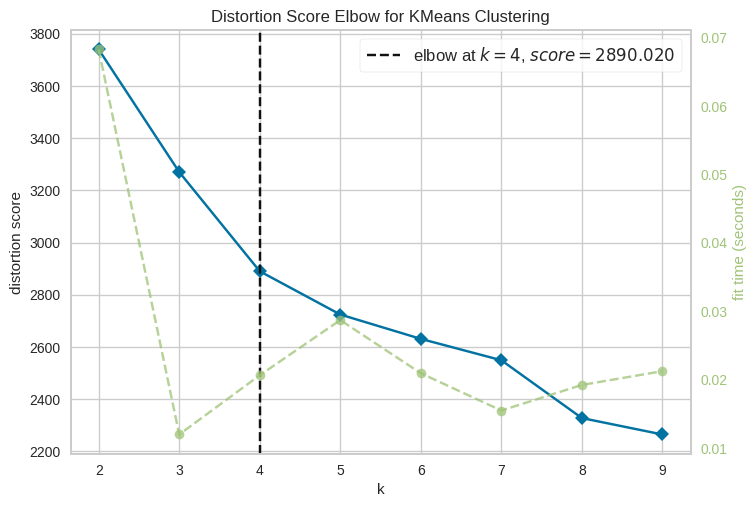

In [27]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import matplotlib.pyplot as plt

# Inisialisasi MiniBatchKMeans
cluster_model = KMeans(random_state=42)

# Visualisasi menggunakan KElbowVisualizer untuk mencari jumlah klaster yang optimal
visualizer = KElbowVisualizer(cluster_model, k=(2, 10))
visualizer.fit(transformed_data.to_numpy())
visualizer.show()

# Menampilkan plot
plt.show()

In [28]:
from sklearn.cluster import KMeans

# Inisialisasi KMeans dengan jumlah klaster optimal yang diperoleh dari visualizer
model = KMeans(n_clusters=visualizer.elbow_value_, random_state=42)

# Fit dan prediksi labels menggunakan KMeans
labels = model.fit_predict(transformed_data.to_numpy())

# Mengubah label dari 0-based menjadi 1-based
labels = labels + 1

# Menampilkan labels yang diperoleh
print(f'Labels: {labels}')


Labels: [3 1 4 ... 3 3 3]


In [29]:
print(f'Davies-Bouldin index = {davies_bouldin_score(transformed_data.to_numpy(), labels)}')
print(f'Silhouette Score     = {silhouette_score(transformed_data.to_numpy(), labels)}')

Davies-Bouldin index = 1.4720528919173377
Silhouette Score     = 0.24584231829254294


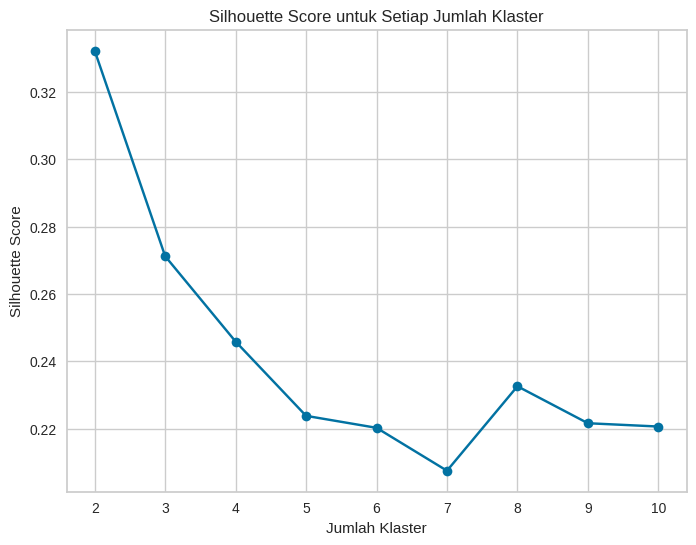

In [30]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Inisialisasi KMeans
cluster_model = KMeans(random_state=42)

# Tentukan jumlah klaster yang akan diuji
k_values = range(2, 11)  # Misalnya, kita uji jumlah klaster antara 3 dan 10
silhouette_scores = []

# Loop untuk menguji silhouette score dengan jumlah klaster yang berbeda
for k in k_values:
    cluster_model.n_clusters = k
    cluster_model.fit(transformed_data)  # Fit data pada model
    score = silhouette_score(transformed_data, cluster_model.labels_)  # Hitung silhouette score
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score untuk Setiap Jumlah Klaster')
plt.xlabel('Jumlah Klaster')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

# Menampilkan nilai silhouette score terbaik
best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

# Profilisasi Cluster


In [31]:
import pandas as pd

# Buat DataFrame untuk menyimpan hasil clustering dalam bentuk awal (standardized)
df_clustered = pd.DataFrame(transformed_data, columns=feature_names)  # Data sebelum inverse transform
df_clustered['cluster'] = labels  # Tambahkan hasil clustering

# Hitung rata-rata per klaster
profiling_result = df_clustered.groupby('cluster').mean()

# Tampilkan hasil
print(profiling_result)

            price  review_scores_rating  accommodates  bedrooms      beds  \
cluster                                                                     
1        0.119922              0.788340      0.397759  0.327731  0.253782   
2        0.053721              0.621242      0.168908  0.285714  0.050316   
3        0.104465              0.588163      0.327953  0.272718  0.161409   
4        0.214398              0.596037      0.813753  0.715684  0.808112   

         host_is_superhost  availability_365  number_of_reviews  \
cluster                                                           
1                 1.000000          0.639191           0.525888   
2                 0.197785          0.733685           0.303070   
3                 0.000000          0.630189           0.223937   
4                 0.072727          0.657074           0.178231   

         distance_to_city  host_response_time_encoded  ...  max_property_type  \
cluster                                              

In [ ]:
transformed_data['label'] = labels
pca = PCA(n_components=3)

principal_components = pca.fit_transform(transformed_data.drop('label', axis=1))
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'])
principal_df['label'] = transformed_data['label']
principal_df

,PC1,PC2,PC3,label
0,0.299477,0.179811,-0.273660,3
1,0.304840,0.959485,-0.146131,1
2,0.970291,-0.260793,0.848342,4
3,0.420533,-0.180221,-0.368431,3
4,0.754485,-0.155590,0.600499,4
...,...,...,...,...
3813,0.840650,-0.520774,0.432123,4
3814,0.477936,-0.123969,-0.094823,3
3815,0.270426,-0.163605,-0.483744,3
3816,0.237419,-0.129351,-0.661619,3


In [ ]:
import pandas as pd

# Buat DataFrame untuk menyimpan hasil clustering dalam bentuk awal (standardized)
df_clustered = pd.DataFrame(transformed_data, columns=feature_names)  # Data sebelum inverse transform
df_clustered['cluster'] = labels  # Tambahkan hasil clustering

# Hitung rata-rata per klaster
profiling_result = df_clustered.groupby('cluster').mean()

# Tampilkan hasil
profiling_result

,price,review_scores_rating,accommodates,bedrooms,beds,host_is_superhost,availability_365,number_of_reviews,distance_to_city,host_response_time_encoded,...,max_property_type,median_property_type,room_type_Entire Home/Apt,room_type_Private Room,room_type_Shared Room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-Out Sofa,bed_type_Real Bed
cluster,,,,,,,,,,,,,,,,,,,,,
1,0.119922,0.788340,0.397759,0.327731,0.253782,1.000000,0.639191,0.525888,0.322729,0.128151,...,0.947678,0.589005,0.981092,0.000000,0.018908,0.004202,0.002101,0.016807,0.006303,0.970588
2,0.053721,0.621242,0.168908,0.285714,0.050316,0.197785,0.733685,0.303070,0.402856,0.188027,...,0.928688,0.536174,0.000000,0.917722,0.082278,0.015823,0.007911,0.039557,0.024525,0.912184
3,0.104465,0.588163,0.327953,0.272718,0.161409,0.000000,0.630189,0.223937,0.283726,0.212766,...,0.949377,0.602666,1.000000,0.000000,0.000000,0.003668,0.001467,0.011739,0.008070,0.975055
4,0.214398,0.596037,0.813753,0.715684,0.808112,0.072727,0.657074,0.178231,0.371673,0.237762,...,0.965502,0.545524,0.994406,0.000000,0.005594,0.000000,0.000000,0.000000,0.002797,0.997203


# Scatter Plot PCA

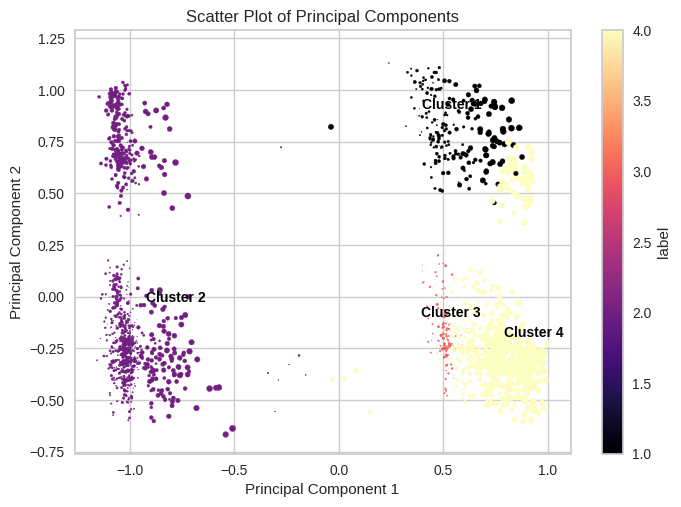

In [ ]:
ax = principal_df.plot.scatter(
    x='PC1',
    y='PC2',
    s=principal_df['PC3'] * 20,
    c='label',
    colormap='magma'
)

centers = principal_df.groupby('label')[['PC1', 'PC2']].mean()
for label, (x, y) in centers.iterrows():
    plt.annotate(f'Cluster {label}', (x, y), textcoords="offset points", xytext=(5,5), ha='left', fontsize=10, color='black', weight='bold')

plt.title('Scatter Plot of Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [ ]:
listings_selected_copy['cluster'] = labels
listings_selected_copy

,room_type,price,review_scores_rating,accommodates,bedrooms,beds,bed_type,host_is_superhost,bathrooms,availability_365,number_of_reviews,city_normalized,distance_to_city,host_response_time_encoded,mean_property_type,max_property_type,median_property_type,cluster
0,Entire Home/Apt,85.0,95.0,4.0,1.0,1.0,Real Bed,0,1.0,346,62.0,Seattle,4.439052,2,122.932670,999.0,110.0,3
1,Entire Home/Apt,150.0,96.0,4.0,1.0,1.0,Real Bed,1,1.0,291,43.0,Seattle,4.441933,1,122.932670,999.0,110.0,1
2,Entire Home/Apt,975.0,97.0,7.0,3.5,3.5,Real Bed,0,1.0,220,20.0,Seattle,3.833194,2,132.344291,1000.0,95.0,4
3,Entire Home/Apt,100.0,96.0,3.0,0.0,2.0,Real Bed,0,1.0,143,0.0,Seattle,4.543407,1,122.932670,999.0,110.0,3
4,Entire Home/Apt,450.0,92.0,6.0,3.0,3.0,Real Bed,0,1.0,365,38.0,Seattle,4.240533,1,132.344291,1000.0,95.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,Entire Home/Apt,359.0,88.0,6.0,3.0,3.0,Real Bed,0,1.0,32,1.0,Seattle,6.770782,2,132.344291,1000.0,95.0,4
3814,Entire Home/Apt,79.0,100.0,4.0,1.0,2.0,Real Bed,0,1.0,273,2.0,Seattle,4.930030,1,122.932670,999.0,110.0,3
3815,Entire Home/Apt,93.0,96.0,2.0,1.0,1.0,Real Bed,0,1.0,88,0.0,Seattle,12.855801,1,132.344291,1000.0,95.0,3
3816,Entire Home/Apt,99.0,96.0,2.0,0.0,1.0,Real Bed,0,1.0,179,0.0,Seattle,5.140297,1,151.109890,700.0,115.0,3


# Eksplorasi Data per Cluster


In [ ]:
def plot_pie_chart(data):
    clusters = listings_selected_copy['cluster'].unique()
    num_clusters = len(clusters)

    rows = (num_clusters // 3) + (num_clusters % 3 > 0)
    cols = min(4, num_clusters)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).flatten()

    for i, cluster in enumerate(clusters):
        cluster_data = listings_selected_copy[listings_selected_copy['cluster'] == cluster]
        property_counts = cluster_data[data].value_counts()
        axes[i].pie(property_counts, labels=property_counts.index, autopct='%1.1f%%', startangle=140)
        axes[i].set_title(f'Cluster {cluster}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_histogram(data):
    clusters = sorted(listings_selected_copy['cluster'].unique())  # Urutkan cluster 1,2,3,4
    num_clusters = len(clusters)

    rows = (num_clusters // 3) + (num_clusters % 3 > 0)
    cols = min(4, num_clusters)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    axes = np.array(axes).flatten()

    cluster_colors = {1: 'blue', 2: 'green', 3: 'orange', 4: 'red'}  # Warna khusus untuk cluster tertentu

    for i, cluster in enumerate(clusters):
        cluster_data = listings_selected_copy[listings_selected_copy['cluster'] == cluster]
        sns.histplot(cluster_data, x=data, color=cluster_colors.get(cluster, 'gray'), kde=True, bins=20, ax=axes[i])
        axes[i].set_title(f'Cluster {cluster}')
        axes[i].set_xlabel(data)
        axes[i].set_ylabel('Frequency')

    for j in range(i + 1, len(axes)):  # Hapus sisa subplot yang tidak terpakai
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [ ]:
#plot_pie_chart('property_type')

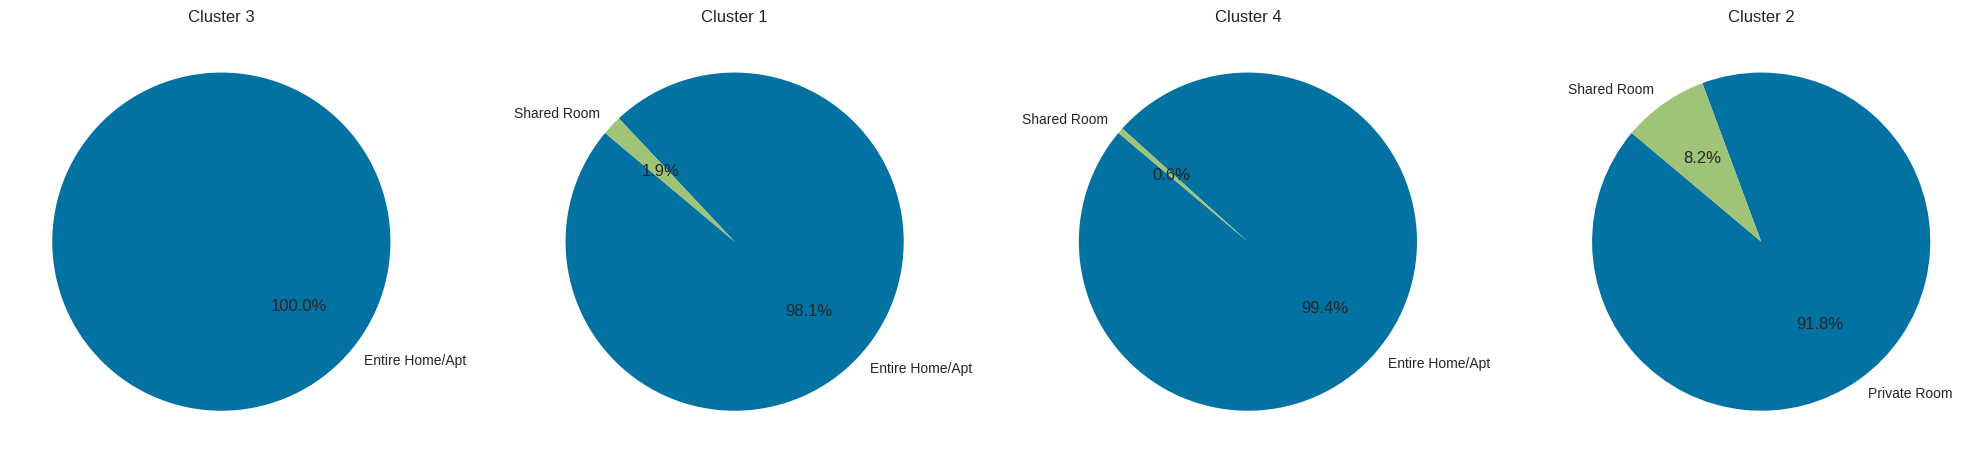

In [ ]:
plot_pie_chart('room_type')

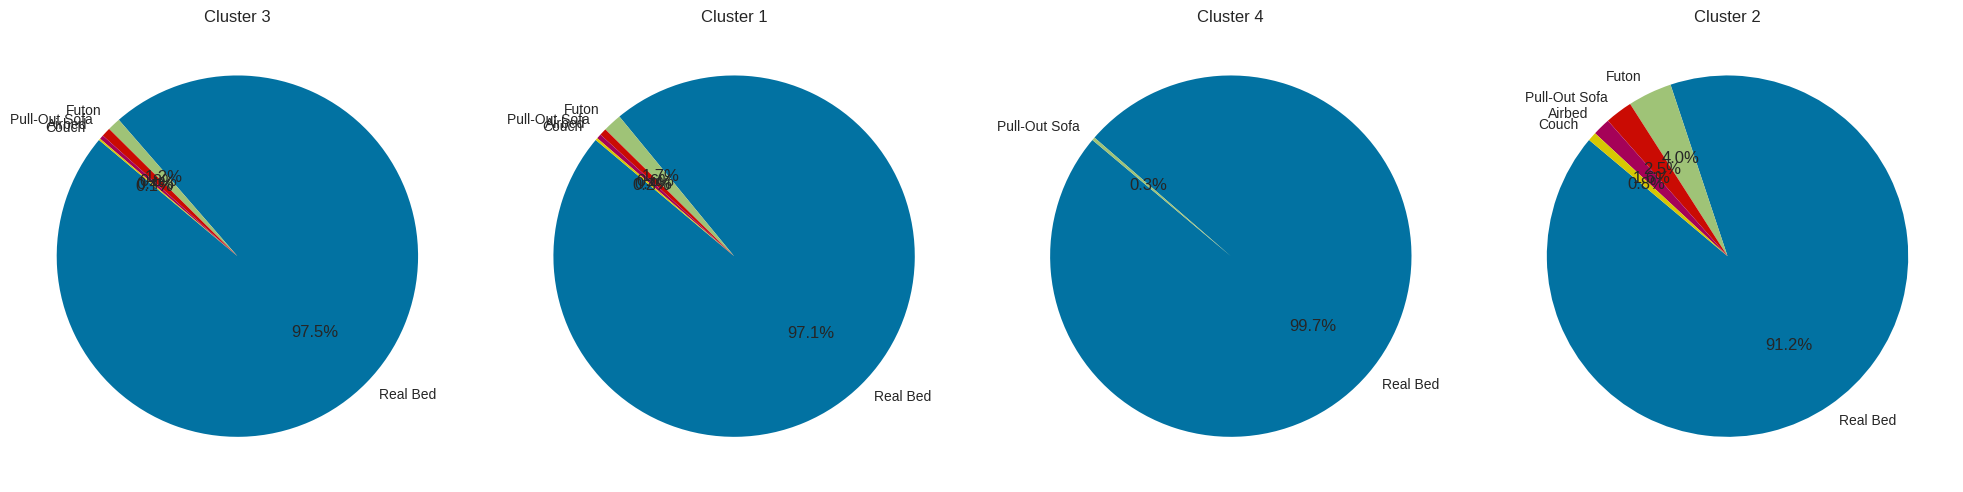

In [ ]:
plot_pie_chart('bed_type')

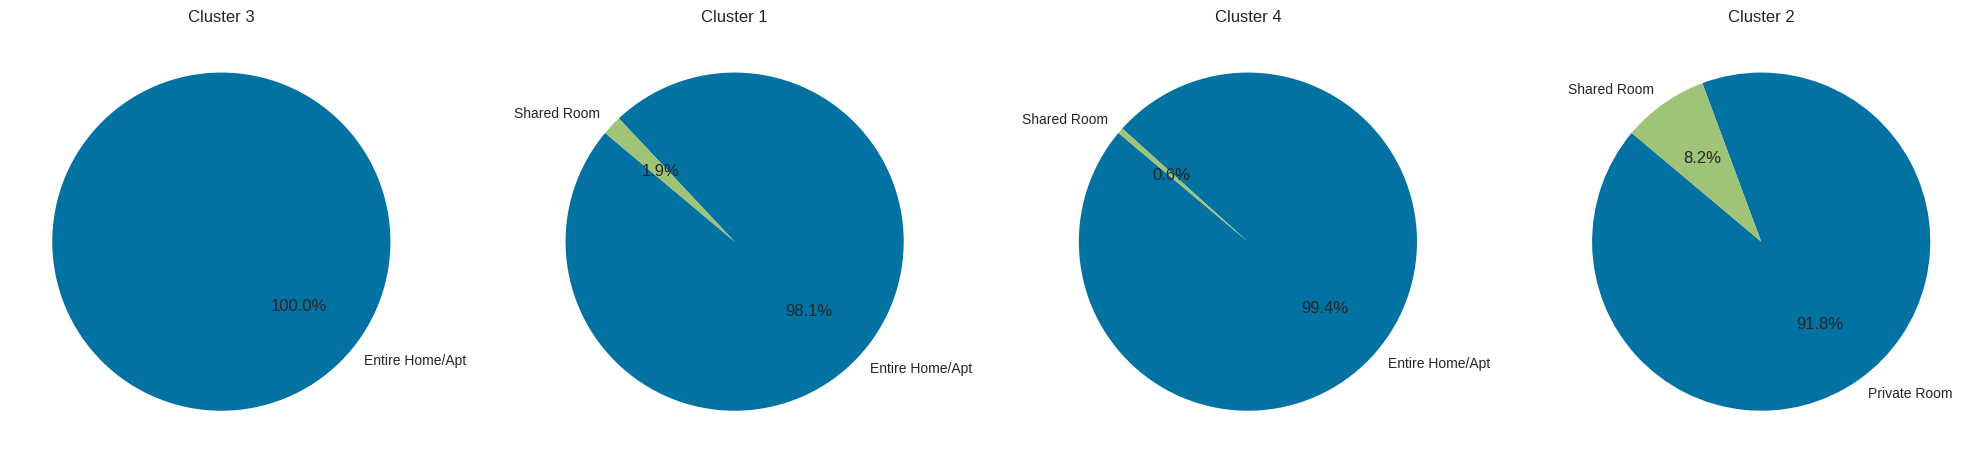

In [ ]:
plot_pie_chart('room_type')

In [ ]:
#plot_pie_chart('host_response_time')

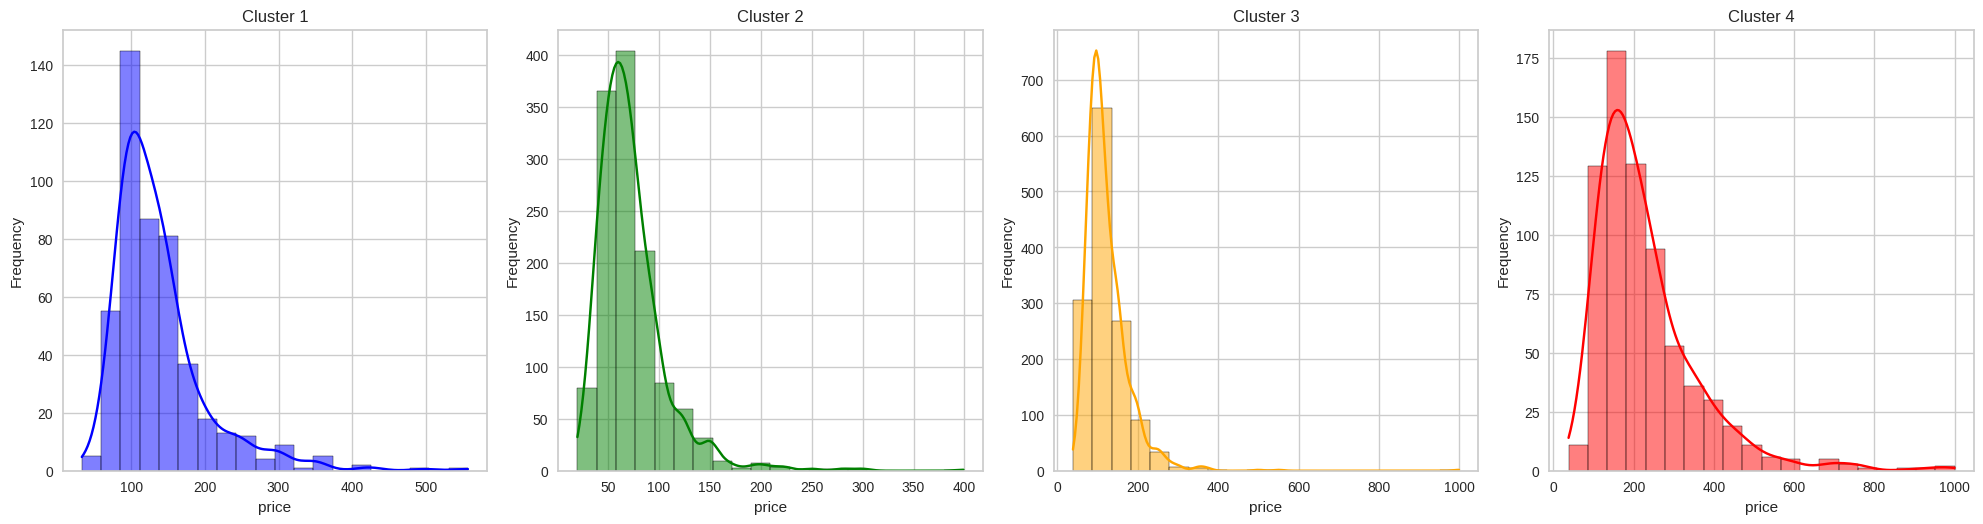

In [ ]:
plot_histogram('price')

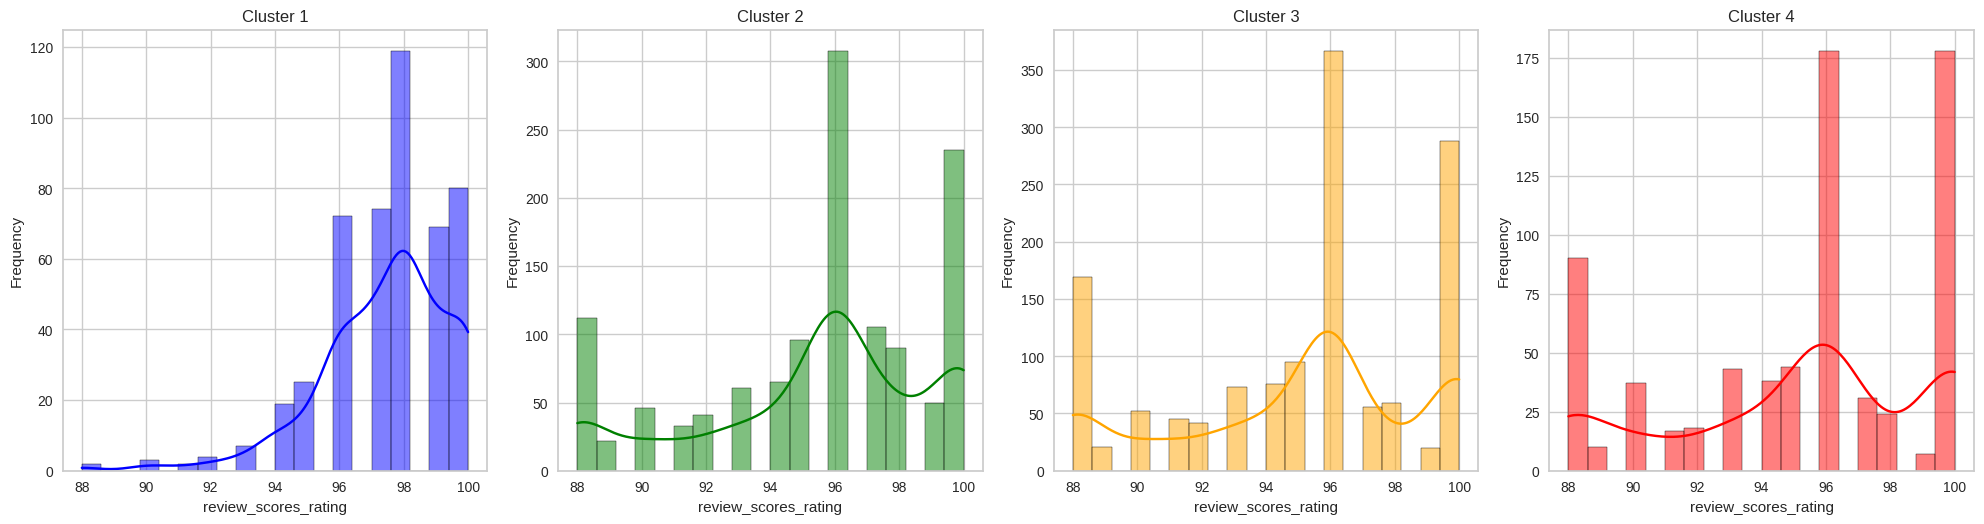

In [ ]:
plot_histogram('review_scores_rating')

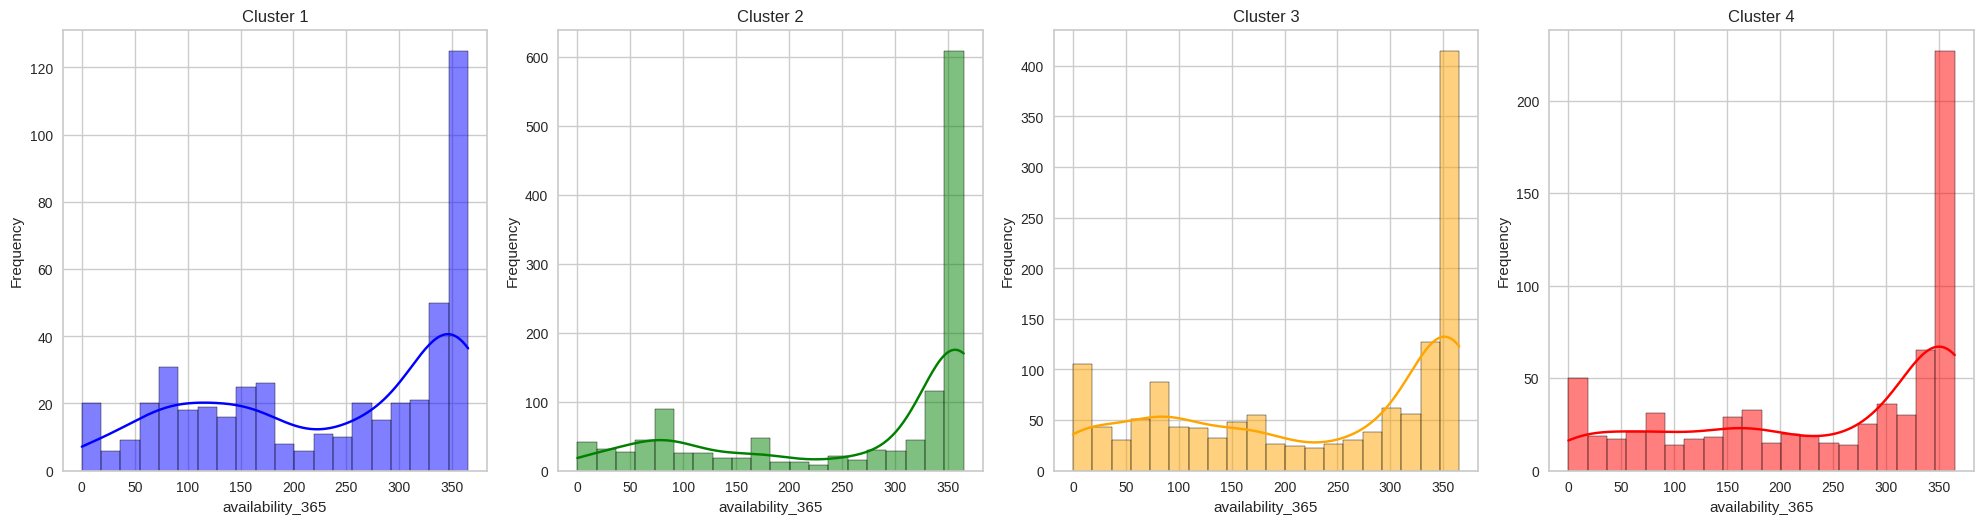

In [ ]:
plot_histogram('availability_365')

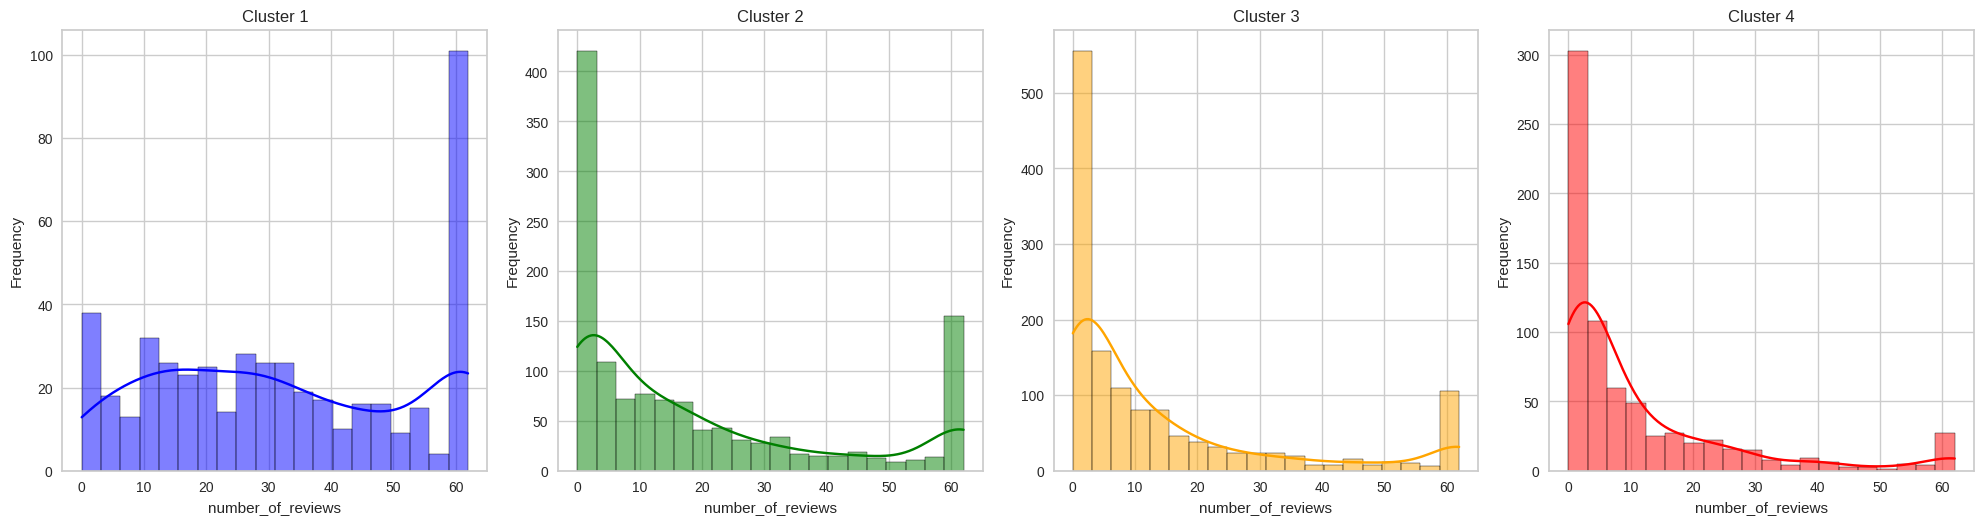

In [ ]:
plot_histogram('number_of_reviews')

In [ ]:
import pandas as pd
from google.colab import files

file_id = '1kIXpkpjEmonYCn_VNw7a-2p1CflaAuoa'
url = f'https://drive.google.com/uc?export=download&id={file_id}'
gdown.download(url, 'data.csv', quiet=False)

d_listing1 = pd.read_csv('data.csv')
d_listing1.head

Downloading...
From: https://drive.google.com/uc?export=download&id=1kIXpkpjEmonYCn_VNw7a-2p1CflaAuoa
To: /content/data.csv
100%|██████████| 16.9M/16.9M [00:00<00:00, 68.8MB/s]


<bound method NDFrame.head of             id                            listing_url       scrape_id  \
0       241032    https://www.airbnb.com/rooms/241032  20160104002432   
1       953595    https://www.airbnb.com/rooms/953595  20160104002432   
2      3308979   https://www.airbnb.com/rooms/3308979  20160104002432   
3      7421966   https://www.airbnb.com/rooms/7421966  20160104002432   
4       278830    https://www.airbnb.com/rooms/278830  20160104002432   
...        ...                                    ...             ...   
3813   8101950   https://www.airbnb.com/rooms/8101950  20160104002432   
3814   8902327   https://www.airbnb.com/rooms/8902327  20160104002432   
3815  10267360  https://www.airbnb.com/rooms/10267360  20160104002432   
3816   9604740   https://www.airbnb.com/rooms/9604740  20160104002432   
3817  10208623  https://www.airbnb.com/rooms/10208623  20160104002432   

     last_scraped                                 name  \
0      2016-01-04         Stylish Queen Anne Apartment   
1      2016-01-04   Bright & Airy Queen Anne Apartment   
2      2016-01-04  New Modern House-Amazing water view   
3      2016-01-04                   Queen Anne Chateau   
4      2016-01-04       Charming craftsman 3 bdm house   
...           ...                                  ...   
3813   2016-01-04   3BR Mountain View House in Seattle   
3814   2016-01-04    Portage Bay View!-One Bedroom Apt   
3815   2016-01-04    Private apartment view of Lake WA   
3816   2016-01-04    Amazing View with Modern Comfort!   
3817   2016-01-04            Large Lakefront Apartment   

                                                summary  \
0                                                   NaN   
1     Chemically sensitive? We've removed the irrita...   
2     New modern house built in 2013.  Spectacular s...   
3     A charming apartment that sits atop Queen Anne...   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...   
3814  800 square foot 1 bedroom basement apartment w...   
3815  Very comfortable lower unit. Quiet, charming m...   
3816  Cozy studio condo in the heart on Madison Park...   
3817  All hardwood floors, fireplace, 65" TV with Xb...   

                                                  space  \
0     Make your self at home in this charming one-be...   
1     Beautiful, hypoallergenic apartment in an extr...   
2     Our house is modern, light and fresh with a wa...   
3                                                   NaN   
4     Cozy family craftman house in beautiful neighb...   
...                                                 ...   
3813  Our 3BR/2BA house bright, stylish, and wheelch...   
3814  This space has a great view of Portage Bay wit...   
3815                                                NaN   
3816  Fully furnished unit to accommodate most needs...   
3817                                                NaN   

                                            description experiences_offered  \
0     Make your self at home in this charming one-be...                none   
1     Chemically sensitive? We've removed the irrita...                none   
2     New modern house built in 2013.  Spectacular s...                none   
3     A charming apartment that sits atop Queen Anne...                none   
4     Cozy family craftman house in beautiful neighb...                none   
...                                                 ...                 ...   
3813  Our 3BR/2BA house boasts incredible views of t...                none   
3814  800 square foot 1 bedroom basement apartment w...                none   
3815  Very comfortable lower unit. Quiet, charming m...                none   
3816  Cozy studio condo in the heart on Madison Park...                none   
3817  All hardwood floors, fireplace, 65" TV with Xb...                none   

                             

In [ ]:
import numpy as np
import pandas as pd

# Membuat dictionary untuk menyesuaikan nama kota yang ada pada dataset
city_mapping = {
    'Seattle': 'Seattle',
    'Phinney Ridge Seattle': 'Seattle',
    'West Seattle': 'Seattle',
    'Ballard, Seattle': 'Seattle',
    '西雅图': 'Seattle',  # 'Xīyátú' untuk Seattle dalam Mandarin
    # Jika ada nama kota lain dalam bahasa atau format berbeda, bisa ditambahkan di sini
}

# Mengganti nama kota di kolom 'city' dengan nama kota yang konsisten
d_listing1['city_normalized'] = d_listing1['city'].map(city_mapping).fillna(d_listing1['city'])

# Memeriksa nilai unik pada kolom 'city' untuk verifikasi
print("Unique cities in the original 'city' column:")
print(d_listing1['city'].unique())

# Memeriksa nilai yang terdeteksi sebagai 'NaN' pada 'city_normalized'
print("Cities with 'NaN' in 'city_normalized' after mapping:")
print(d_listing1[d_listing1['city_normalized'].isna()]['city'].unique())

# Koordinat pusat kota untuk beberapa kota (contoh: Seattle)
city_coordinates = {
    'Seattle': (47.6062, -122.3321),
    # Tambahkan koordinat kota lain jika ada
}

# Menambah koordinat untuk kota lainnya jika diperlukan
city_coordinates.update({
    'New York': (40.7128, -74.0060),
    'Los Angeles': (34.0522, -118.2437),
    # Tambahkan kota lain jika diperlukan
})

# Fungsi untuk mendapatkan koordinat kota
def get_city_coordinates(city_name):
    return city_coordinates.get(city_name, (None, None))

# Menambahkan kolom latitude dan longitude pusat kota
d_listing1['city_lat'], d_listing1['city_lon'] = zip(*d_listing1['city_normalized'].apply(get_city_coordinates))

# Fungsi Haversine untuk menghitung jarak ke pusat kota
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius bumi dalam km
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Jarak dalam km

# Menghitung jarak ke pusat kota untuk setiap listing
d_listing1['distance_to_city'] = d_listing1.apply(
    lambda x: haversine(x['latitude'], x['longitude'], x['city_lat'], x['city_lon']) if x['city_lat'] and x['city_lon'] else None, axis=1
)

Unique cities in the original 'city' column:
['Seattle' 'Ballard, Seattle' 'West Seattle' 'Seattle ' '西雅图'
 'Phinney Ridge Seattle' 'seattle']
Cities with 'NaN' in 'city_normalized' after mapping:
[]


In [ ]:
import pandas as pd
from google.colab import files
!pip install xlsxwriter

# Pastikan panjang dataframe sama sebelum menambahkan kolom cluster
if len(d_listing1) == len(df_clustered):
    d_listing1["cluster"] = df_clustered["cluster"].values  # Tambahkan kolom cluster

    # Sheet 2: Profiling hasil clustering
    profiling_result = df_clustered.groupby("cluster").mean()

    # Sheet 3: Profiling dari mean data asli (listings_selected_copy)
    listings_selected_copy["cluster"] = df_clustered["cluster"].values  # Tambahkan cluster ke data asli
    profiling_mean_original = listings_selected_copy.groupby("cluster").mean(numeric_only=True)

    # Simpan ke file Excel dengan multiple sheets
    file_path = "Hasil Clustering KMeans.xlsx"
    with pd.ExcelWriter(file_path, engine="xlsxwriter") as writer:
        d_listing1.to_excel(writer, sheet_name="Data_Clustered", index=False)  # Sheet 1
        profiling_result.to_excel(writer, sheet_name="Profiling_Result")  # Sheet 2
        profiling_mean_original.to_excel(writer, sheet_name="Profiling_Mean_Original")  # Sheet 3

    # Download ke lokal
    files.download(file_path)

    print(f"File berhasil disimpan dan diunduh: {file_path}")

else:
    print("Error: Panjang d_listing1 dan df_clustered tidak sama!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 3.4 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File berhasil disimpan dan diunduh: Hasil Clustering KMeans.xlsx
